# Project 5: Customer Segmentation with Clustering

### Step 1: Setup - Importing Libraries and Loading Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set_style('whitegrid')

In [3]:
# Load the dataset from the user-provided file
!git clone "https://github.com/HarshvardhanSingh-13/Datasets"
df = pd.read_csv('/content/Datasets/Mall Dataset/Mall_Customers.csv')

print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head(10)

Cloning into 'Datasets'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 347 (delta 25), reused 0 (delta 0), pack-reused 242 (from 1)
Receiving objects: 100% (347/347), 302.89 MiB | 19.38 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (245/245), done.
Dataset loaded successfully.
Data shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


### Step 2: In-Depth Exploratory Data Analysis (EDA)
Before clustering, we must understand the features and their relationships to find the most promising dimensions for segmentation.

In [ ]:
# Basic info and statistics
print("Dataset Info:")
df.info()

# Drop the CustomerID as it's just an identifier and not useful for clustering
df.drop('CustomerID', axis=1, inplace=True)

print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive Statistics:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     4

#### 2.1 Univariate Analysis (Feature Distributions)

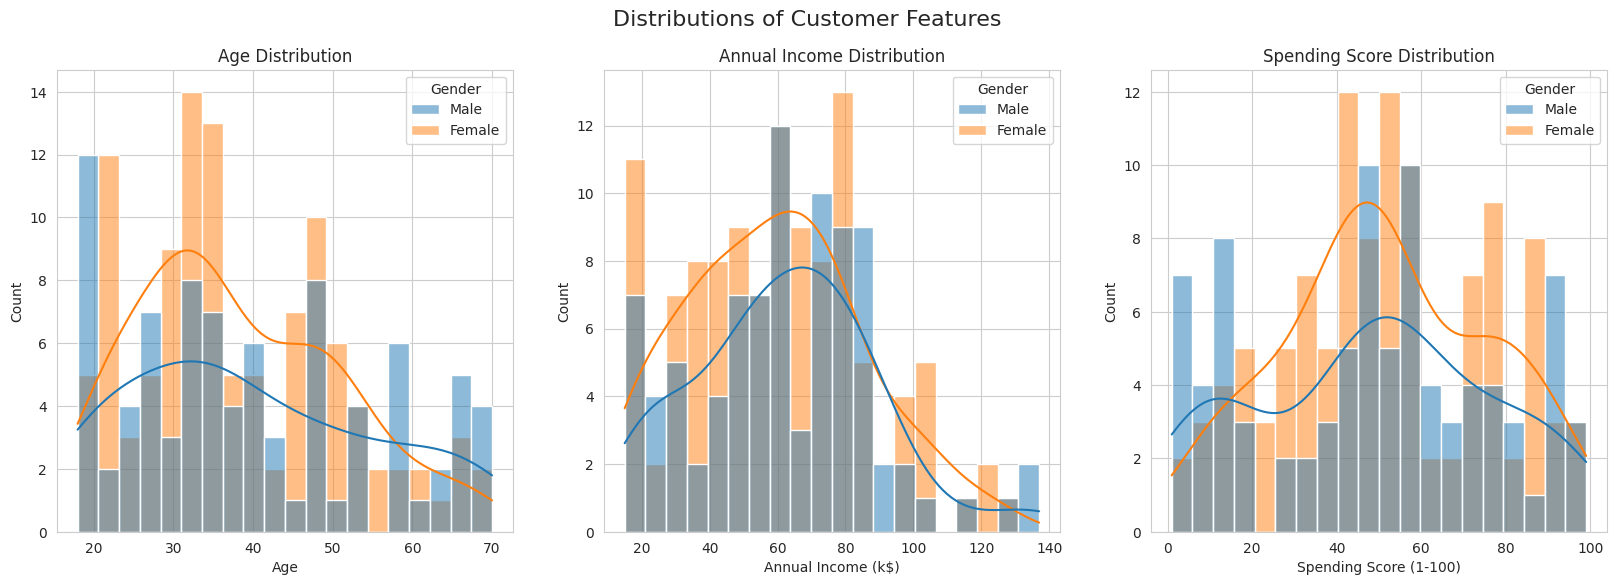

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Customer Features', fontsize=16)

sns.histplot(ax=axes[0], data=df, x='Age', kde=True, bins=20, hue='Gender').set_title('Age Distribution')
sns.histplot(ax=axes[1], data=df, x='Annual Income (k$)', kde=True, bins=20, hue='Gender').set_title('Annual Income Distribution')
sns.histplot(ax=axes[2], data=df, x='Spending Score (1-100)', kde=True, bins=20, hue='Gender').set_title('Spending Score Distribution')

plt.show()

#### 2.2 Bivariate Analysis (Looking for Relationships)

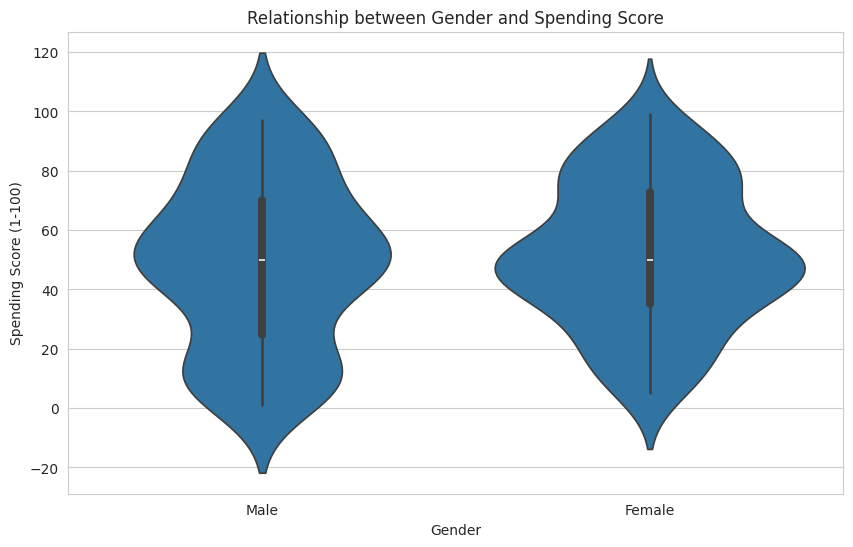

In [11]:
#using violin plot to visualize the relation between gender and spending score
plt.figure(figsize=(10, 6))
sns.violinplot(x='Gender', y='Spending Score (1-100)', data=df)
plt.title('Relationship between Gender and Spending Score')
plt.show()

### Insights
1. Male and Female have a similar spending behaviour
2. Female customers show stronger concentration in mid-to-high spending ranges, while males are more spread out.
3. Many low to mid spenders in the male category and mid to high in the female category
4. Since both the categories overlap heavily we cannot seperate them into clusters .



#### 2.3 3D Visualization
Let's visualize the three most important features together in an interactive 3D plot to see if the clusters hold up.

In [ ]:
# fig = px.scatter_3d(df,
#                     x='Annual Income (k$)',
#                     y='Spending Score (1-100)',
#                     z='Age',
#                     color='Gender',
#                     title='3D View of Customer Data')
# fig.show()

## **Feature Engineering**

In [12]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

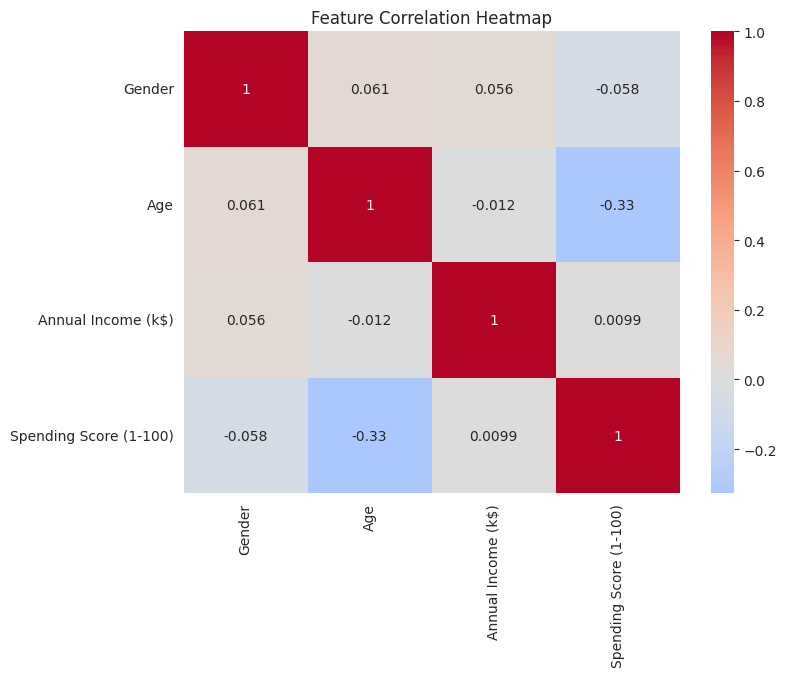

In [16]:
df.drop('CustomerID', axis=1, inplace=True)
corr_mat = df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

In [17]:
variances = df.var().sort_values(ascending=False)
print(variances)


Annual Income (k$)        689.835578
Spending Score (1-100)    666.854271
Age                       195.133166
Gender                      0.247638
dtype: float64


# **Submission**
1. Only Annual Income and spending score have positive correlation
2. Since Annual Income and Spending Scores have high variance they are most suitable for clustering followed by Age.

In [19]:
df['spending_efficiency'] = (
    df['Spending Score (1-100)'] / df['Annual Income (k$)']
)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),spending_efficiency
0,1,19,15,39,2.600000
1,1,21,15,81,5.400000
2,0,20,16,6,0.375000
3,0,23,16,77,4.812500
4,0,31,17,40,2.352941


# **Submission**



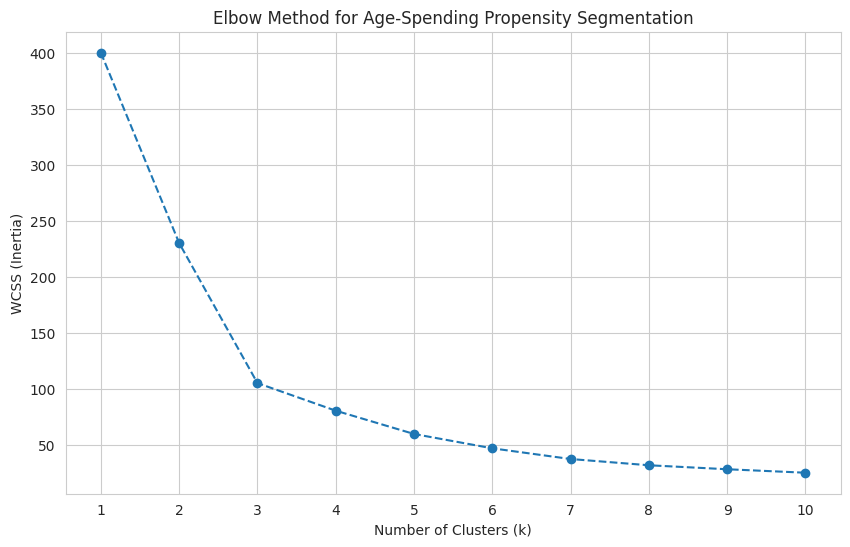

In [20]:
# plotting Elbow curve to find the k value

X = df[['Age', 'spending_efficiency']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# 5. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending Propensity Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

In [29]:
kmeans1 = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
df['spending_eff_Cluster'] = kmeans1.fit_predict(X_scaled)

# **Submission**

 Using the Elbow Method we can take k = 3

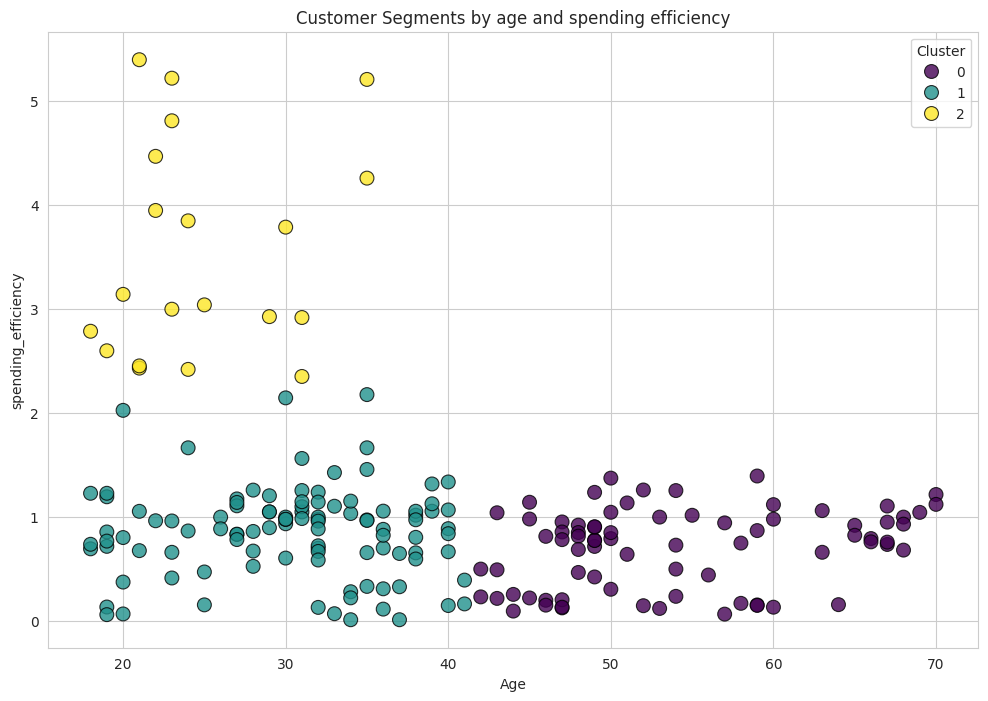

In [30]:
# visualizing the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Age', y='spending_efficiency',
                hue='spending_eff_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by age and spending efficiency')
plt.legend(title='Cluster')
plt.show()

In [33]:
cluster_profiles = df.groupby('spending_eff_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
cluster_profiles['Size'] = df['spending_eff_Cluster'].value_counts().sort_index()

print("--- Spending Efficency Based Cluster Profiles ---")

cluster_profiles

--- Spending Efficency Based Cluster Profiles ---


,Age,Annual Income (k$),Spending Score (1-100),Size
spending_eff_Cluster,,,,
0,54.04,57.49,36.18,76
1,30.44,70.03,55.18,104
2,24.85,23.00,77.55,20


## **Conclusion**

**Cluster 0** consists of older individuals with an average age of 54 years. They have a moderate annual income of about 57.5k and a low spending score of 36, indicating cautious spending behavior. The cluster has 76 people.

**Cluster 1** consists of younger individuals with an average age of 30 years. They have a higher annual income of around 70k and a moderate spending score of 55, indicating average spending behavior. This is the largest cluster with 104 people.

**Cluster 2** consists of the youngest individuals with an average age of 25 years. They have the lowest income of 23k but the highest spending score of 77, indicating high spending relative to their income. This is the smallest cluster with 20 people.

### Step 3: Segmentation Model 1 - Income & Spending Score
This is our primary segmentation model, focusing on the most promising features identified in the EDA.

In [ ]:
# # 1. Select and scale the features
# X1 = df[['Annual Income (k$)', 'Spending Score (1-100)']]
# scaler1 = StandardScaler()
# X1_scaled = scaler1.fit_transform(X1)

# # 2. Implement the Elbow Method
# wcss1 = []
# for k in range(1, 11):
#     kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
#     kmeans.fit(X1_scaled)
#     wcss1.append(kmeans.inertia_)

# # 3. Plot the Elbow Curve
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
# plt.title('Elbow Method for Income-Spending Segmentation')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('WCSS (Inertia)')
# plt.xticks(range(1, 11))
# plt.show()

In [ ]:
# # 1. Select and scale the features
# X1 = df[['', 'Spending Score (1-100)']]
# scaler1 = StandardScaler()
# X1_scaled = scaler1.fit_transform(X1)

# # 2. Implement the Elbow Method
# wcss1 = []
# for k in range(1, 11):
#     kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
#     kmeans.fit(X1_scaled)
#     wcss1.append(kmeans.inertia_)

# # 3. Plot the Elbow Curve
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
# plt.title('Elbow Method for Income-Spending Segmentation')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('WCSS (Inertia)')
# plt.xticks(range(1, 11))
# plt.show()

**Observation:** The "elbow" of the curve is clearly at **k=5**. The WCSS decreases sharply until k=5, and then the rate of decrease flattens out. This confirms our visual intuition from the scatter plot!

In [ ]:
# # Build and fit the final model
# kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
# df['Income_Cluster'] = kmeans1.fit_predict(X1_scaled)

#### 3.1 Visualizing and Interpreting the Income-Based Segments

In [ ]:
# plt.figure(figsize=(12, 8))
# sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
#                 hue='Income_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
# plt.title('Customer Segments by Income and Spending')
# plt.legend(title='Cluster')
# plt.show()

In [ ]:
# Quantitative Persona Analysis
# cluster_profiles1 = df.groupby('Income_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
# cluster_profiles1['Size'] = df['Income_Cluster'].value_counts()
# print("--- Income-Based Cluster Profiles ---")
# cluster_profiles1

### Step 4: Segmentation Model 2 - Age & Spending Score
Let's create a different segmentation model to see if we can find age-related customer groups.

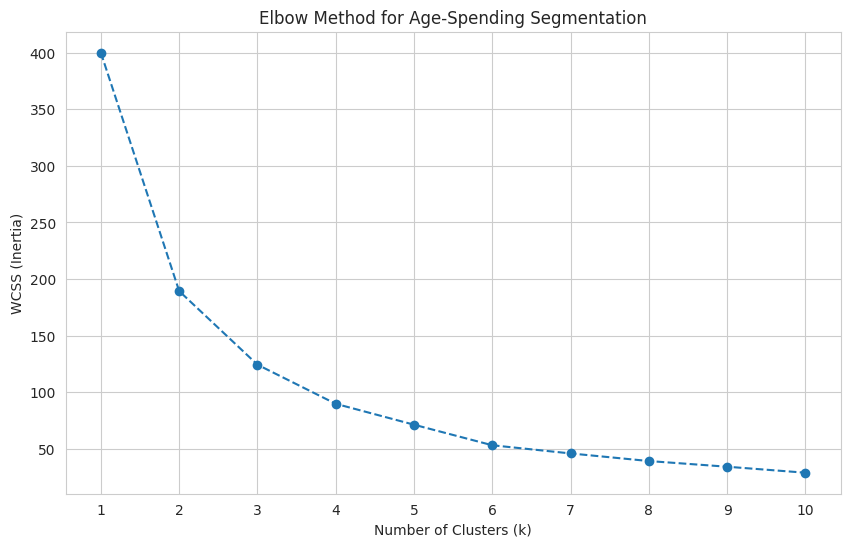

In [ ]:
# # 1. Select and scale the features
# X2 = df[['Age', 'Spending Score (1-100)']]
# scaler2 = StandardScaler()
# X2_scaled = scaler2.fit_transform(X2)

# # 2. Implement the Elbow Method
# wcss2 = []
# for k in range(1, 11):
#     kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
#     kmeans.fit(X2_scaled)
#     wcss2.append(kmeans.inertia_)

# # 3. Plot the Elbow Curve
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, 11), wcss2, marker='o', linestyle='--')
# plt.title('Elbow Method for Age-Spending Segmentation')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('WCSS (Inertia)')
# plt.xticks(range(1, 11))
# plt.show()

In [ ]:
# # Build and fit the final model for age segmentation
# kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
# df['Age_Cluster'] = kmeans2.fit_predict(X2_scaled)

# # Visualize the new clusters
# plt.figure(figsize=(12, 8))
# sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
#                 hue='Age_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
# plt.title('Customer Segments by Age and Spending')
# plt.legend(title='Cluster')
# plt.show()

### Step 5: An Alternative Method - Hierarchical Clustering
To add more depth, let's briefly look at another clustering technique.

In [ ]:
# plt.figure(figsize=(20, 10))
# dendrogram = sch.dendrogram(sch.linkage(X1_scaled, method='ward'))
# plt.title('Dendrogram for Income-Spending Data')
# plt.xlabel('Customers')
# plt.ylabel('Euclidean Distances')
# plt.axhline(y=6, color='r', linestyle='--') # Example cut-off line
# plt.show()

**Insight:** The dendrogram also confirms that **5 clusters** is the optimal number for the income-spending data. If we draw a horizontal line at a height of 6 (as shown by the red dashed line), it crosses five vertical lines.

### Submission Criteria

Based on the project objectives and the insights gained from the initial analysis, here are the key criteria for your submission:

1.  **Explore Gender vs. Spending Score:** Analyze the relationship between 'Gender' and 'Spending Score (1-100)' to see if gender plays a significant role in spending habits. Visualizations and summary statistics would be helpful here.
2.  **Apply Feature Engineering for Clustering:** Create a new feature using existing data (Feature Engineering). Then, explore if clustering can be effectively performed using this newly engineered feature in combination with one or more existing features. Document the feature engineering process, the chosen features for clustering, the determination of the optimal number of clusters (e.g., using the Elbow Method), and the resulting cluster visualization and interpretation.